# Principal Component Analysis (PCA)
We will implement the PCA algorithm. We will first implement PCA, then apply it (once again) to the MNIST digit dataset.

## Learning objective
1. Write code that implements PCA.
2. Write code that implements PCA for high-dimensional datasets

Let's first import the packages we need for this week.

In [1]:
# PACKAGE: DO NOT EDIT
import numpy as np
import scipy
import scipy.stats

In [2]:
import matplotlib.pyplot as plt
from ipywidgets import interact

plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
from load_data import load_mnist

MNIST = load_mnist('./tmp2')
images, labels = MNIST['data'], MNIST['target']

Now, let's plot a digit from the dataset:

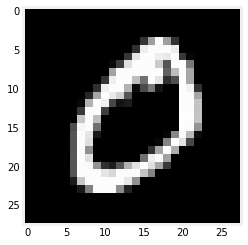

In [4]:
plt.figure(figsize=(4,4))
plt.imshow(images[0].reshape(28,28), cmap='gray');
plt.grid(False)

## PCA

Now we will implement PCA. Before we do that, let's pause for a moment and
think about the steps for performing PCA. Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $M$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).
3. Compute the orthogonal projection matrix and use that to project the data onto the subspace spanned by the eigenvectors.

### Data normalization `normalize`

We will first implement the data normalization mentioned above.

Before we implement the main steps of PCA, we will need to do some data preprocessing.

To preprocess the dataset for PCA, we will make sure that the dataset has zero mean. Given a dataset $\mathbf{X}$, we will subtract the mean vector from each row of the dataset to obtain a zero-mean dataset $\overline{\mathbf{X}}$. In the first part of this notebook, you will implement `normalize` to do that.

To work with images, it's also a common practice to convert the pixels from unsigned interger 8 (uint8) encoding to a floating point number representation between 0-1. We will do this conversion for you for the MNIST dataset so that you don't have to worry about it.

Data normalization is a common practice. More details can be found in
[Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).

In [5]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def normalize(X):
    """Normalize the given dataset X to have zero mean.
    Args:
        X: ndarray, dataset of shape (N,D)
    
    Returns:
        (Xbar, mean): tuple of ndarray, Xbar is the normalized dataset
        with mean 0; mean is the sample mean of the dataset.
    """
    # YOUR CODE HERE
    ### Uncomment and modify the code below
    N, D = X.shape
    mu = X.mean(axis = 0) # <-- EDIT THIS, compute the mean of X
    Xbar = X - mu # <-- EDIT THIS, compute the normalized data Xbar
    return Xbar, mu

In [6]:
"""Test data normalization"""
from numpy.testing import assert_allclose


X0 = np.array([[0, 0.0], 
               [1.0, 1.0], 
               [2.0, 2.0]])
X0_normalize, X0_mean = normalize(X0)
# Test that normalized data has zero mean
assert_allclose(np.mean(X0_normalize, 0), np.zeros((2,)))
assert_allclose(X0_mean, np.array([1.0, 1.0]))
assert_allclose(normalize(X0_normalize)[0], X0_normalize)


X0 = np.array([[0, 0.0], 
               [1.0, 0.0], 
               [2.0, 0.0]])
X0_normalize, X0_mean = normalize(X0)
# Test that normalized data has zero mean and unit variance
assert_allclose(np.mean(X0_normalize, 0), np.zeros((2,)))
assert_allclose(X0_mean, np.array([1.0, 0.0]))
assert_allclose(normalize(X0_normalize)[0], X0_normalize)

# Some hidden tests below
# ...

### Compute eigenvalues and eigenvectors `eig`

In [7]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix

    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs should be sorted in descending
        order of the eigen values
    """
    # YOUR CODE HERE
    # Uncomment and modify the code below
    # Compute the eigenvalues and eigenvectors
    # You can use library routines in `np.linalg.*` 
    # https://numpy.org/doc/stable/reference/routines.linalg.html
    # for this
    eigvals, eigvecs = np.linalg.eig(S)
    # The eigenvalues and eigenvectors need to be
    # sorted in descending order according to the eigenvalues
    # We will use `np.argsort` (https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html)
    # to find a permutation of the indices
    # of eigvals that will sort eigvals in ascending order and
    # then find the descending order via [::-1], which reverse
    # the indices
    sort_indices = np.argsort(eigvals)[::-1]
    # Notice that we are sorting the columns (not rows) of
    # eigvecs since the columns represent the eigenvectors.
    return eigvals[sort_indices], eigvecs[:, sort_indices]

Some test cases for implementing `eig`.

In [8]:
def _flip_eigenvectors(B):
    """Flip the eigenvectors.    
    """
    signs = np.sign(B[np.argmax(np.abs(B), axis=0), range(B.shape[1])])
    return B * signs

def _normalize_eigenvectors(B):
    # Normalize eigenvectors to have unit length
    # Also flip the direction of the eigenvector based on
    # the first element
    B_normalized = B / np.linalg.norm(B, axis=0)
    for i in range(B.shape[1]):
        if (B_normalized[0, i] < 0):
            B_normalized[:, i] = -B_normalized[:, i]
    return B_normalized


A = np.array([[3, 2], [2, 3]])
expected_eigenvalues = np.array([5., 1.])
expected_eigenvectors = np.array(
    [[ 0.70710678, -0.70710678],
     [ 0.70710678,  0.70710678]]
)
actual_eigenvalues, actual_eigenvectors = eig(A)
# Check that the eigenvalues match
assert_allclose(actual_eigenvalues, expected_eigenvalues)
# Check that the eigenvectors match
assert_allclose(
    _normalize_eigenvectors(actual_eigenvectors),
    _normalize_eigenvectors(expected_eigenvectors),
)


### Compute projection matrix

Next given a orthonormal basis spanned by the eigenvectors,
we will compute the projection matrix. This should be the same
as what you have done last week.

In [9]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    # YOUR CODE HERE
    # Uncomment and modify the code below
    return B @ np.linalg.inv(B.T @ B) @ B.T # <-- EDIT THIS to compute the projection matrix

In [10]:
B = np.array([[1, 0],
              [1, 1],
              [1, 2]])

assert_allclose(
    projection_matrix(B), 
    np.array([[5,  2, -1],
              [2,  2,  2],
              [-1, 2,  5]]) / 6
)

# Some hidden tests below

### Compute principal component analysis

In [11]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def PCA(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        the reconstructed data, the sample mean of the X, principal values
        and principal components
    """

    # YOUR CODE HERE
    N, D = X.shape
    # your solution should take advantage of the functions you have implemented above.
    ### Uncomment and modify the code below
    # first perform normalization on the digits so that they have zero mean and unit variance
    X_normalized, mean = normalize(X) # EDIT THIS
    # Then compute the data covariance matrix S
    S = np.cov(X_normalized/N, rowvar=False, bias=True) # EDIT THIS

    # Next find eigenvalues and corresponding eigenvectors for S
    eig_vals, eig_vecs = eig(S)
    # Take the top `num_components` of eig_vals and eig_vecs,
    # This will be the corresponding principal values and components
    principal_vals, principal_components = eig_vals[:num_components], eig_vecs[:, :num_components]
    
    # reconstruct the data from the using the basis spanned by the principal components
    # Notice that we have subtracted the mean from X so make sure that you add it back
    # to the reconstructed data
    P = projection_matrix(np.real(principal_components))
    reconst = (P @ X_normalized.T).T + mean
    return reconst, mean, principal_vals, principal_components

In [12]:
def draw_vector(v0, v1, ax=None, label=None):
    """Draw a vector from v0 to v1."""
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, 
                    color='k')
    ax.annotate('', v1, v0, arrowprops=arrowprops, label=label)

Some test cases that check the implementation of PCA

In [13]:
D = 2
N = 10
# Generate a dataset X from a 2D Gaussian distribution
mvn = scipy.stats.multivariate_normal(
    mean=np.ones(D, dtype=np.float64), 
    cov=np.array([[1, 0.8], [0.8, 1]], dtype=np.float64)
)

X = mvn.rvs((N,), random_state=np.random.RandomState(0))
reconst, m, pv, pc = PCA(X, 1)
# Check the shape returned by the PCA implementation matches the specification.
assert reconst.shape == X.shape
assert m.shape == (D, )
assert pv.shape == (1, )
assert pc.shape == (D, 1)

# Check that PCA with num_components == D gives identical reconstruction
reconst, m, pv, pc = PCA(X, D)
assert reconst.shape == X.shape
assert m.shape == (D, )
assert pv.shape == (2, )
assert pc.shape == (D, 2)
assert_allclose(reconst, X)



## Visualize PCA
We will first visualize what PCA does on a 2D toy dataset. You can use the visualization
below to get better intuition about what PCA does and use it to debug your code above.

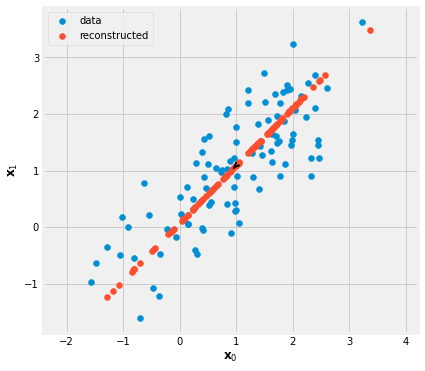

In [14]:
mvn = scipy.stats.multivariate_normal(
    mean=np.ones(2), 
    cov=np.array([[1, 0.8], [0.8, 1]])
)

X = mvn.rvs((100,), random_state=np.random.RandomState(0))

num_components = 1
X_reconst, mean, principal_values, principal_components = PCA(X, num_components)

fig, ax = plt.subplots(figsize=(6, 6))
# eig_vals, eig_vecs = eig_vals[:num_components], eig_vecs[:, :num_components]
ax.scatter(X[:, 0], X[:, 1], label='data')
for (princial_variance, principal_component) in (zip(principal_values, principal_components.T)):
    draw_vector(
        mean, mean + np.sqrt(princial_variance) * principal_component, 
        ax=ax)
ax.scatter(X_reconst[:, 0], X_reconst[:, 1], label='reconstructed')
plt.axis('equal');
plt.legend();
ax.set(xlabel='$\mathbf{x}_0$', ylabel='$\mathbf{x}_1$');

We can also compare our PCA implementation with the implementation in scikit-learn (a popular machine learning library in Python that includes implementation of PCA)
to see
if we get identical results.

In [15]:
random = np.random.RandomState(0)
X = random.randn(10, 5)

from sklearn.decomposition import PCA as SKPCA

for num_component in range(1, 4):
    # We can compute a standard solution given by scikit-learn's implementation of PCA
    pca = SKPCA(n_components=num_component, svd_solver="full")
    sklearn_reconst = pca.inverse_transform(pca.fit_transform(X))
    reconst, _, _, _ = PCA(X, num_component)
    # The difference in the result should be very small (<10^-20)
    print(
        "difference in reconstruction for num_components = {}: {}".format(
            num_component, np.square(reconst - sklearn_reconst).sum()
        )
    )
    np.testing.assert_allclose(reconst, sklearn_reconst)

difference in reconstruction for num_components = 1: 6.2310381862738e-29
difference in reconstruction for num_components = 2: 1.0099518850468333e-28
difference in reconstruction for num_components = 3: 3.7166981252773755e-29


## PCA for MNIST digits

Once you have implemented PCA correctly, it's time to apply to the MNIST dataset.
First, we will do some preprocessing of the data to get it into a good shape.

In [16]:
## Some preprocessing of the data
NUM_DATAPOINTS = 1000
X = (images.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.

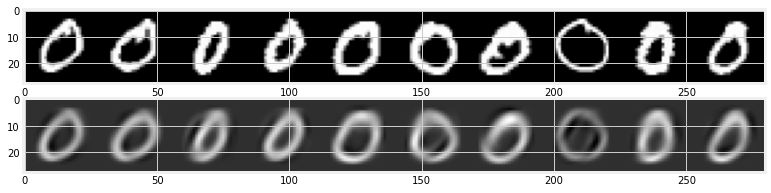

In [17]:
reconst, _, _, _ = PCA(X, num_components=10)
num_images_to_show = 10
reconst_images = np.reshape(reconst[:num_images_to_show], (-1, 28, 28))
fig, ax = plt.subplots(2, 1, figsize=(num_images_to_show * 3, 3))
ax[0].imshow(np.concatenate(np.reshape(X[:num_images_to_show], (-1, 28, 28)), -1), cmap="gray")
ax[1].imshow(np.concatenate(reconst_images, -1), cmap="gray");

The greater number of of principal components we use, the smaller will our reconstruction
error be. Now, let's answer the following question: 


> How many principal components do we need
> in order to reach a Mean Squared Error (MSE) of less than $10.0$ for our dataset?



We have provided a function in the next cell which computes the mean squared error (MSE), which will be useful for answering the question above.

In [18]:
def mse(predict, actual):
    """Helper function for computing the mean squared error (MSE)"""
    return np.square(predict - actual).sum(axis=1).mean()

In [19]:
loss = []
reconstructions = []
# iterate over different number of principal components, and compute the MSE
for num_component in range(1, 100, 5):
    reconst, _, _, _ = PCA(X, num_component)
    error = mse(reconst, X)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions
loss = np.asarray(loss)

In [20]:
import pandas as pd
# create a table showing the number of principal components and MSE
pd.DataFrame(loss, columns=['no. of components', 'mse']).head()

,no. of components,mse
0,1.0,40.618882
1,6.0,23.198508
2,11.0,16.899711
3,16.0,13.367106
4,21.0,11.072143


We can also put these numbers into perspective by plotting them.

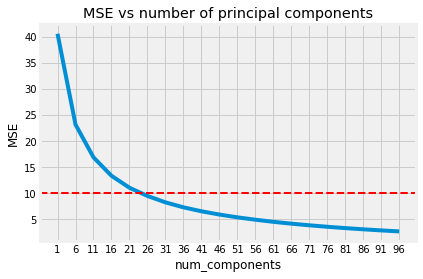

In [21]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(10, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

But _numbers dont't tell us everything_! Just what does it mean _qualitatively_ for the loss to decrease from around
$45.0$ to less than $10.0$?

Let's find out! In the next cell, we draw the the leftmost image is the original dight. Then we show the reconstruction of the image on the right, in descending number of principal components used.

In [22]:
@interact(image_idx=(0, 1000))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    # concatenate the actual and reconstructed images as large image before plotting it
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

interactive(children=(IntSlider(value=500, description='image_idx', max=1000), Output()), _dom_classes=('widge…

We can also browse through the reconstructions for other digits. Once again, `interact` becomes handy for visualing the reconstruction.

In [23]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    """Show the i th digit and its reconstruction"""
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :]).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.grid(False)
    plt.show()

interactive(children=(IntSlider(value=1, description='i', max=10), Output()), _dom_classes=('widget-interact',…

## PCA for high-dimensional datasets

Sometimes, the dimensionality of our dataset may be larger than the number of samples we
have. Then it might be inefficient to perform PCA with your implementation above. Instead,
as mentioned in the lectures, you can implement PCA in a more efficient manner, which we
call "PCA for high dimensional data" (PCA_high_dim).

Below are the steps for performing PCA for high dimensional dataset
1. Normalize the dataset matrix $X$ to obtain $\overline{X}$ that has zero mean.
2. Compute the matrix $\overline{X}\overline{X}^T$ (a $N$ by $N$ matrix with $N << D$)
3. Compute eigenvalues $\lambda$s and eigenvectors $V$ for $\overline{X}\overline{X}^T$ with shape (N, N). Compare this with computing the eigenspectrum of $\overline{X}^T\overline{X}$ which has shape (D, D), when $N << D$, computation of the eigenspectrum of $\overline{X}\overline{X}^T$ will be computationally less expensive.
4. Compute the eigenvectors for the original covariance matrix as $\overline{X}^TV$. Choose the eigenvectors associated with the `n` largest eigenvalues to be the basis of the principal subspace $U$.
    1. Notice that $\overline{X}^TV$ would give a matrix of shape (D, N) but the eigenvectors beyond the Dth column will have eigenvalues of 0, so it is safe to drop any columns beyond the D'th dimension. 
    2. Also note that the columns of $U$ will not be unit-length if we pre-multiply $V$ with $\overline{X}^T$, so we will have to normalize the columns of $U$ so that they have unit-length to be consistent with the `PCA` implementation above.
5. Compute the orthogonal projection of the data onto the subspace spanned by columns of $U$. 

Functions you wrote for earlier assignments will be useful.

In [24]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def PCA_high_dim(X, num_components):
    """Compute PCA for small sample size but high-dimensional features. 
    Args:
        X: ndarray of size (N, D), where D is the dimension of the sample,
           and N is the number of samples
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: (N, D) ndarray. the reconstruction
        of X from the first `num_components` pricipal components.
    """
    # YOUR CODE HERE
    # Uncomment and modify the code below
    N, D = X.shape
    # Normalize the dataset
    X_normalized, mean = normalize(X)
    # Find the covariance matrix
    M = np.dot(X_normalized, X_normalized.T) / N
    # Next find eigenvalues and corresponding eigenvectors for S
    # Make sure that you only take the first D eigenvalues/vectors
    # You can also take a look at the eigenvalues beyond column (D-1) and they should be 
    # zero (or a very small number due to finite floating point precision)
    eig_vals, eig_vecs = eig(M)
    # Compute the eigenvalues and eigenvectors for the original system
    #eig_vecs = X_normalized.T @ eig_vecs_[:,:D]
    #S = np.cov(eig_vecs_, rowvar=False, bias=True)
    #eig_vals, eig_vecs = eig(S)
    
    # Normalize the eigenvectors to have unit-length
    # Take the top `num_components` of the eigenvalues / eigenvectors
    # as the principal values and principal components
    principal_vals, principal_components = eig_vals[:num_components], eig_vecs[:, :num_components]
    
    # reconstruct the images from the lower dimensional representation
    # Remember to add back the sample mean
    #B = np.real(principal_components)
    P = projection_matrix(principal_components)
    reconst = (P @ X_normalized) + mean
    return reconst, mean, principal_vals, principal_components

In [25]:
# YOUR CODE HERE

In [26]:
# Some hidden tests below
### ...

Given the same dataset, `PCA_high_dim` and `PCA` should give the same output. 
Assuming we have implemented `PCA`, correctly, we can then use `PCA` to test the correctness
of `PCA_high_dim`. Given the same dataset, `PCA` and `PCA_high_dim` should give identical results.

We can use this __invariant__
to test our implementation of PCA_high_dim, assuming that we have correctly implemented `PCA`.

In [27]:
random = np.random.RandomState(0)
# Generate some random data
X = random.randn(5, 4)
pca_rec, pca_mean, pca_pvs, pca_pcs = PCA(X, 2)
pca_hd_rec, pca_hd_mean, pca_hd_pvs, pca_hd_pcs = PCA_high_dim(X, 2)
# Check that the results returned by PCA and PCA_high_dim are identical
np.testing.assert_allclose(pca_rec, pca_hd_rec)
np.testing.assert_allclose(pca_mean, pca_hd_mean)
np.testing.assert_allclose(pca_pvs, pca_pvs)
np.testing.assert_allclose(pca_pcs, pca_pcs)

_Congratulations_! You have now learned how PCA works!